In [1]:
import torch
import numpy as np
import torch_geometric.utils as U
from torch import tanh as tanh
from torch import sigmoid as sigmoid
from torch import softmax as softmax
from torch_geometric.datasets import TUDataset


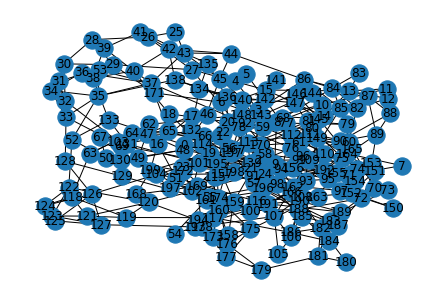

In [2]:
import networkx as nx 
n = 200
G = nx.connected_watts_strogatz_graph(n, k=4, p=0.4)
nx.draw(G, with_labels=True)
G0 = U.from_networkx(G)
edge_index = G0.edge_index
G0.x = torch.randn(n,3) # feature_size = 3
x = G0.x

In [8]:
# edge_score: o(E)
def get_edge_score(edge_index=torch.tensor([]), x=torch.tensor([]), score_method='lin'):
    if type(score_method) in [int, float]:
        pdist = torch.nn.PairwiseDistance(score_method)
        edge_score = pdist(x[edge_index[0]], x[edge_index[1]])
    else:
        in_channels = x.shape[1]
        lin = torch.nn.Linear(2*in_channels, 1)
        if score_method == 'softmax':
            e = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1) + torch.cat([x[edge_index[1]], x[edge_index[0]]], dim=-1)
            edge_score = softmax(lin(e).view(-1), dim=0)
        elif score_method == 'tanh':
            e = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1) + torch.cat([x[edge_index[1]], x[edge_index[0]]], dim=-1)
            edge_score = tanh(lin(e).view(-1))
        elif score_method == 'sigmoid':
            e = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1) + torch.cat([x[edge_index[1]], x[edge_index[0]]], dim=-1)
            edge_score = sigmoid(lin(e).view(-1))
        elif score_method == 'lin':
            e = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1) + torch.cat([x[edge_index[1]], x[edge_index[0]]], dim=-1)
            edge_score = lin(e).view(-1) 
        else:
            print('Wrong method input')
    return edge_score
# Test 
edge_score = get_edge_score(edge_index=edge_index, x=x, score_method='lin')
edge_score

tensor([ 1.2851e+00,  9.2292e-01,  2.5309e+00,  2.0317e+00,  1.2851e+00,
        -3.7196e-01,  1.6850e+00, -5.8733e-01,  2.9811e-01,  9.2292e-01,
        -7.3409e-01, -4.6007e-01, -4.0287e-01,  7.6970e-01,  4.7152e-01,
        -3.4348e-01, -3.7196e-01, -7.3409e-01,  5.5166e-01, -8.6396e-01,
         9.7254e-01,  5.5166e-01,  1.3934e+00,  1.1272e+00,  1.3934e+00,
         1.3108e+00, -4.3437e-01,  1.1272e+00,  1.3108e+00,  2.1122e+00,
         1.6024e+00,  8.1252e-01,  3.3626e+00,  8.1807e-01,  2.1122e+00,
         1.1698e+00,  1.1812e+00,  1.1698e+00, -4.8180e-01, -3.9831e-01,
         1.1812e+00, -3.6207e-01,  4.2714e-01, -3.6207e-01, -2.1231e-01,
        -1.2859e-01, -2.1231e-01, -4.3412e-01,  1.1466e-01, -1.2859e-01,
        -4.3412e-01,  1.9838e-01, -4.6573e-01,  1.1466e-01,  1.9838e-01,
         8.3046e-02,  2.2972e+00,  6.1478e-01, -4.6573e-01,  8.3046e-02,
         1.5641e-01,  4.6250e-01,  4.4460e-01,  1.3702e+00, -1.4214e+00,
         1.6972e-01,  1.5641e-01,  4.4460e-01,  9.6

In [6]:
# node_score o(E)
def get_node_score(edge_score=torch.tensor([]), edge_index=torch.tensor([])):
    num_nodes = torch.max(edge_index) + 1
    node_min_score = torch.tensor([])
    node_max_score = torch.tensor([])
    node_avg_score = torch.tensor([])
    node_score_dict = {}
    # Initialize dict 
    for i in range(num_nodes):
        node_score_dict[i] = torch.tensor([])
    for i in range(edge_score.shape[0]):
        node_score_dict[edge_index[0,i].item()] = torch.cat([node_score_dict[edge_index[0,i].item()], edge_score[i,None]], 0)
        node_score_dict[edge_index[1,i].item()] = torch.cat([node_score_dict[edge_index[1,i].item()], edge_score[i,None]], 0)
    for i in range(num_nodes):
        node_min_score = torch.cat([node_min_score, torch.min(node_score_dict[i], dim=0, keepdim=True).values], 0)
        node_max_score = torch.cat([node_max_score, torch.max(node_score_dict[i], dim=0, keepdim=True).values], 0)
        node_avg_score = torch.cat([node_avg_score, torch.mean(node_score_dict[i], dim=0, keepdim=True)], 0)
    return node_min_score, node_max_score, node_avg_score
    
node_min_score, node_max_score, node_avg_score = get_node_score(edge_score, edge_index)

In [50]:
# strict_dict o(E)
def get_strict_cluster(edge_score, node_min_score, edge_index, p1, p2):
    edge_sep = torch.quantile(node_min_score, q=p1)
    edge_sep_upper = torch.quantile(node_min_score, q=p2)
    num_cluster = -1
    strict_dict = {}
    strict_clustered_nodes = torch.tensor([])
    # strict connected clusters
    for i in range(edge_score.shape[0]):
        if edge_score[i].item() <= edge_sep:
            if (edge_index[0,i] not in strict_clustered_nodes) & (edge_index[1,i] not in strict_clustered_nodes):
                strict_clustered_nodes = torch.cat([strict_clustered_nodes, edge_index[0,i,None], edge_index[1,i,None]], 0)
                num_cluster += 1
                strict_dict[num_cluster] = edge_index[:,i]
            elif (edge_index[0,i]in strict_clustered_nodes) & (edge_index[1,i] not in strict_clustered_nodes):
                strict_clustered_nodes = torch.cat([strict_clustered_nodes, edge_index[1,i,None]], 0)
                for key, value in strict_dict.items():
                    if edge_index[0,i].item() in value:
                        cluster_ind = key
                strict_dict[cluster_ind] = torch.concat([strict_dict[cluster_ind], edge_index[1,i,None]])
            elif (edge_index[0,i] not in strict_clustered_nodes) & (edge_index[1,i] in strict_clustered_nodes):
                strict_clustered_nodes = torch.cat([strict_clustered_nodes, edge_index[0,i,None]], 0)
                for key, value in strict_dict.items():
                    if edge_index[1,i].item() in value:
                        cluster_ind = key
                strict_dict[cluster_ind] = torch.concat([strict_dict[cluster_ind], edge_index[0,i,None]])
            elif (edge_index[0,i] in strict_clustered_nodes) & (edge_index[1,i] in strict_clustered_nodes):
                for key, value in strict_dict.items():
                    if edge_index[0,i].item() in value:
                        cluster_ind0 = key
                    if edge_index[1,i].item() in value:
                        cluster_ind1 = key
                if cluster_ind0 != cluster_ind1:
                    strict_dict[cluster_ind0] = torch.unique(torch.concat([strict_dict[cluster_ind0], strict_dict[cluster_ind1]], 0))
                    strict_dict.pop(cluster_ind1)
    # strict independet clusters
    for i in range(node_min_score.shape[0]):
        if node_min_score[i] > edge_sep_upper:
            num_cluster += 1
            strict_dict[num_cluster] = torch.tensor([i])
            strict_clustered_nodes = torch.cat([strict_clustered_nodes, torch.tensor([i])], 0)
    return strict_dict, strict_clustered_nodes  
strict_dict, strict_clustered_nodes = get_strict_cluster(edge_score, node_min_score, edge_index, p1=0.3, p2=0.9) 
print(strict_dict) 

{0: tensor([ 3, 13, 12]), 1: tensor([4, 6, 7])}


In [53]:
def get_soft_cluster(edge_score, node_min_score, edge_index, strict_dict, strict_clustered_nodes,p1, p2):
    edge_sep = torch.quantile(node_min_score, q=p1)
    edge_sep_upper = torch.quantile(node_min_score, q=p2)
    soft_dict = {}
    full_dict = {}
    for key, value in strict_dict.items():
        full_dict[key] = torch.clone(value)
    soft_clustered_nodes = torch.tensor([])
    num_cluster = -1
    # First, form the soft clusters
    for i in range(edge_score.shape[0]):
        if (edge_index[0,i] not in strict_clustered_nodes) & (edge_index[1,i] in strict_clustered_nodes):
            if edge_index[0,i] not in soft_clustered_nodes:
                num_cluster += 1
                soft_dict[num_cluster] = edge_index[0,i,None]
                soft_clustered_nodes = torch.cat([soft_clustered_nodes, edge_index[0,i,None]], 0)
        
        elif (edge_index[1,i] not in strict_clustered_nodes) & (edge_index[0,i] in strict_clustered_nodes):
            if edge_index[1,i] not in soft_clustered_nodes:
                num_cluster += 1
                soft_dict[num_cluster] = edge_index[1,i,None]
                soft_clustered_nodes = torch.cat([soft_clustered_nodes, edge_index[1,i,None]], 0)


        elif (edge_index[0,i] not in strict_clustered_nodes) & (edge_index[1,i] not in strict_clustered_nodes):
            if (edge_index[0,i] not in soft_clustered_nodes) & (edge_index[1,i] not in soft_clustered_nodes):
                num_cluster += 1
                soft_dict[num_cluster] = edge_index[:,i]  
                soft_clustered_nodes = torch.cat([soft_clustered_nodes, edge_index[0,i,None], edge_index[1,i,None]], 0)


            elif (edge_index[0,i] in soft_clustered_nodes) & (edge_index[1,i] not in soft_clustered_nodes):
                for key, value in soft_dict.items():
                    if edge_index[0,i].item() in value:
                        cluster_ind = key
                soft_dict[cluster_ind] = torch.cat([soft_dict[cluster_ind], edge_index[1,i,None]], 0)
                soft_clustered_nodes = torch.cat([soft_clustered_nodes, edge_index[1,i,None]], 0)

            elif (edge_index[1,i] in soft_clustered_nodes) & (edge_index[0,i] not in soft_clustered_nodes):
                soft_clustered_nodes = torch.cat([soft_clustered_nodes, edge_index[0,i,None]], 0)
                for key, value in soft_dict.items():
                    if edge_index[1,i].item() in value:
                        cluster_ind = key
                soft_dict[cluster_ind] = torch.cat([soft_dict[cluster_ind], edge_index[0,i,None]], 0)

            elif  (edge_index[0,i] in soft_clustered_nodes) & (edge_index[1,i] in soft_clustered_nodes):
                for key, value in soft_dict.items():
                    if edge_index[0,i].item() in value:
                        cluster_ind0 = key
                    if edge_index[1,i].item() in value:
                        cluster_ind1 = key
                if cluster_ind0 != cluster_ind1:
                    soft_dict[cluster_ind0] = torch.unique(torch.cat([soft_dict[cluster_ind0], soft_dict[cluster_ind1]], 0))
                    soft_dict.pop(cluster_ind1)
    # Second, assign soft clusters to strict clusters
    for i in range(edge_score.shape[0]):
        if (edge_index[0,i] in soft_clustered_nodes) & (edge_index[1,i] in strict_clustered_nodes):
            for key, value in strict_dict.items():
                if edge_index[1,i].item() in value:
                    cluster_ind = key 
            for key, value in soft_dict.items():
                if edge_index[0,i].item() in value:
                    full_dict[cluster_ind] = torch.unique(torch.cat([full_dict[cluster_ind], soft_dict[key]], 0))
        if (edge_index[1,i] in soft_clustered_nodes) & (edge_index[0,i] in strict_clustered_nodes):
            for key, value in strict_dict.items():
                if edge_index[0,i].item() in value:
                    cluster_ind = key 
            for key, value in soft_dict.items():
                if edge_index[1,i].item() in value:
                    full_dict[cluster_ind] = torch.unique(torch.cat([full_dict[cluster_ind], soft_dict[key]], 0))
    return full_dict, soft_dict, soft_clustered_nodes
# test
full_dict, soft_dict, soft_clustered_nodes = get_soft_cluster(edge_score, node_min_score, edge_index, strict_dict, strict_clustered_nodes,p1=0.3, p2=0.9)

In [82]:
# Test all nodes are included
def test_completeness(full_dict, node_min_score):
    all_clustered_nodes = torch.tensor([])
    for key, value in full_dict.items():
        all_clustered_nodes = torch.unique(torch.cat([all_clustered_nodes, value], 0))
    for i in range(node_min_score.shape[0]):
        if (i in all_clustered_nodes) == False:
            print(f'{i:05d} is not included')
test_completeness(full_dict, node_min_score)

In [10]:
# could use min_score, max_score or avg_score for each nodes
def get_next_layer(full_dict, aggregate_score, edge_index=torch.tensor([]), x=torch.tensor([])):
    full_dict_keys = list(full_dict.keys())
    num_cluster = len(full_dict_keys)
    num_nodes = aggregate_score.shape[0]
    node_assignment_matrix = torch.zeros(num_cluster, num_nodes)
    score_assignment_matrix =  torch.zeros(num_cluster, num_nodes)
    new_adjacency_matrix = torch.zeros(num_cluster, num_cluster)
    
    new_x = torch.zeros(num_cluster, x.shape[1])
    for i in range(num_cluster):
        for j in full_dict[full_dict_keys[i]]:
            node_assignment_matrix[i,j] = 1
            score_assignment_matrix[i,j] = aggregate_score[j]
    # new_adjacency_matrix = torch.matmul(node_assignment_matrix,node_assignment_matrix.t())
    new_adjacency_matrix = torch.matmul(torch.matmul(node_assignment_matrix,U.to_dense_adj(edge_index)[0]),node_assignment_matrix.t()) 
    new_adjacency_matrix[new_adjacency_matrix>0] = 1
    new_x = torch.matmul(score_assignment_matrix, x)
    return new_adjacency_matrix, new_x, node_assignment_matrix, score_assignment_matrix
new_adjacency_matrix, new_x, node_assignment_matrix, score_assignment_matrix = get_next_layer(full_dict, aggregate_score=node_avg_score, edge_index=edge_index, x=x)

In [11]:
def unpool(new_x, score_assignment_matrix, edge_index):
    x = torch.matmul(torch.nan_to_num(1/score_assignment_matrix.t(),nan=0.0, posinf=0.0, neginf=0.0), new_x)
    return x, edge_index
original_x, original_edge_index = unpool(new_x, score_assignment_matrix, edge_index)

In [130]:
# summary function for forward message passing
# graph = 'directed' / 'undirected' (no need to conisder each edge twice)
# method = 'lin' (edge score is learned using a linear layer based on the node embeddings)
#         int (edge score is learned using pairwise disrance of p=int)
# p: strict assignmnet proportion
# q: soft assignment proportion
dataset = TUDataset('data', name='MUTAG')
dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
data = train_dataset[0]

edge_index = data.edge_index
x = data.x
edge_score = get_edge_score(edge_index=edge_index, x=x, score_method='lin')
node_min_score, node_max_score, node_avg_score = get_node_score(edge_score, edge_index)
strict_dict, strict_clustered_nodes = get_strict_cluster(edge_score, node_min_score, edge_index, p1=0.2, p2=0.9)  
full_dict, soft_dict, soft_clustered_nodes = get_soft_cluster(edge_score, node_min_score, edge_index, strict_dict, strict_clustered_nodes,p1=0.2, p2=0.9)
test_completeness(full_dict, node_min_score)
new_adjacency_matrix, new_x, node_assignment_matrix, score_assignment_matrix = get_next_layer(full_dict, aggregate_score=node_avg_score, edge_index=edge_index, x=x)
new_edge_index= U.remove_self_loops(U.dense_to_sparse(new_adjacency_matrix)[0])[0]
original_x, original_edge_index = unpool(new_x, score_assignment_matrix, edge_index)

In [88]:
G_new = U.to_networkx(data, to_undirected=True)
nx.draw(G_new, with_labels=True)

torch.Size([14])